# PPO vs APPO performance comparison

On a system with multiple cores, APPO may perform better because it samples and executes SGD updates asynchronously, while PPO workers have to sync at each update.

This notebook explores the results of runs performed on the LBL GIG server (16 virtual cores) with APPO and PPO.

The evaluation rounds are turned off, as they may introduce a bias, so only the training time is seen.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def get_stats(pickle_file):
    with open(pickle_file, 'rb') as f:
        trials = pickle.load(f)
        rewards = []
        timestamps = []
        for k, df in trials.items():
            rewards.append(trials[k]['episode_reward_mean'])
            timestamps.append(trials[k]['timestamp'])
    return rewards, timestamps

In [2]:
from  IPython import display

display.IFrame(
    src="https://tensorboard.dev/experiment/am1PqxZgQvi9DxBqxwT8Rg/#scalars&tagFilter=tune%2Fepisode_reward_mean&_smoothingWeight=0.341",
    width="100%", height="800px")

As we can see, using PPO does not seem to affect the time taken per epoch. The two fastest runs were 1h31 (PPO) and  1h34 (APPO). Most of the runs took from 1h40 to 1h50.

But APPO seems to change the way the policy converges. With APPO, the convergence is much slower (epoch-wise).

In [3]:
rewards_appo, timestamps_appo = get_stats('/home/alex/appo_vs_ppo_new_w5/appo.pickle')
rewards_ppo, timestamps_ppo = get_stats('/home/alex/appo_vs_ppo_new_w5/ppo.pickle')

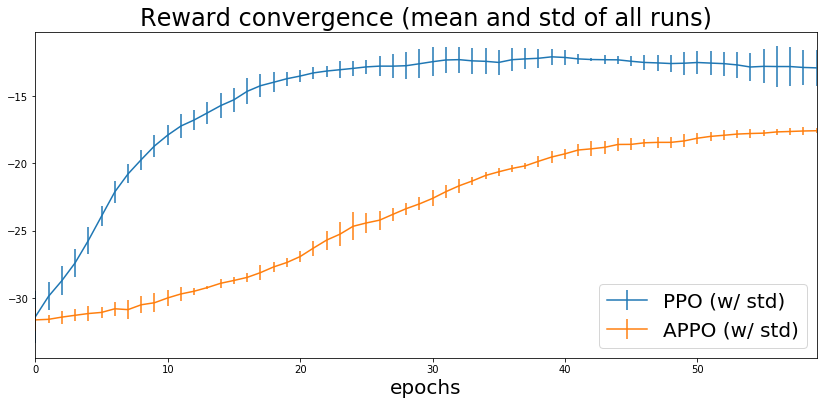

In [4]:
def get_mean_and_std_rewards(dfs):
    df_concat = pd.concat(dfs)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    df_stds = by_row_index.std()
    return df_means, df_stds

m, s = get_mean_and_std_rewards(rewards_ppo)
ax = m.plot(yerr=s, figsize=(14,6))
m, s = get_mean_and_std_rewards(rewards_appo)
ax = m.plot(yerr=s, ax=ax)
ax.legend(['PPO (w/ std)', 'APPO (w/ std)'], fontsize=20)
ax.set_title("Reward convergence (mean and std of all runs)", fontsize=24)
ax.set_xlabel('epochs', fontsize=20);

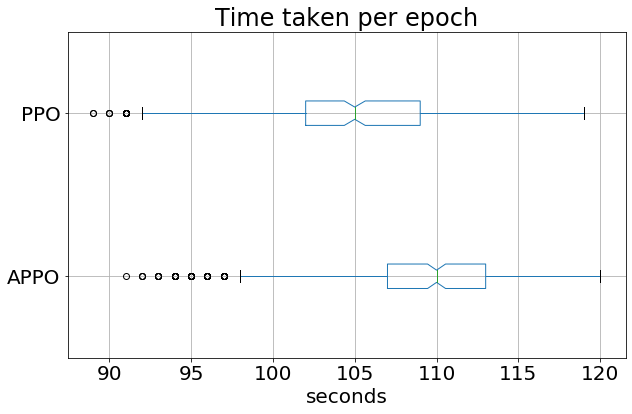

In [5]:
df = pd.DataFrame({'APPO':pd.concat([ts.diff() for ts in timestamps_appo]),
                  'PPO':pd.concat([ts.diff() for ts in timestamps_ppo])})
ax = df.boxplot(notch=True, vert=False, figsize=(10, 6), fontsize=20)
ax.set_xlabel("seconds", fontsize=20);
ax.set_title("Time taken per epoch", fontsize=24);

APPO even seems to be slower per epoch than PPO (on this server).

## 10 workers

Another test was performed with 10 workers. With this amount of workers, the number of training iterations (SGD updates) per epoch differs between APPO and PPO. For 60 epochs, PPO performs 30k steps while APPO performs 60k steps. But these additional steps do not change the convergence, and cause the training for the same number of epochs to be longer, as the number of steps sampled per minute is similar.

In [6]:
display.IFrame(
    src="https://tensorboard.dev/experiment/Q3OWDY9GQSqefVLmIKVyqg/#scalars&tagFilter=(num_steps_trained)%7C(episode_reward_mean)",
    width="100%", height="800px")

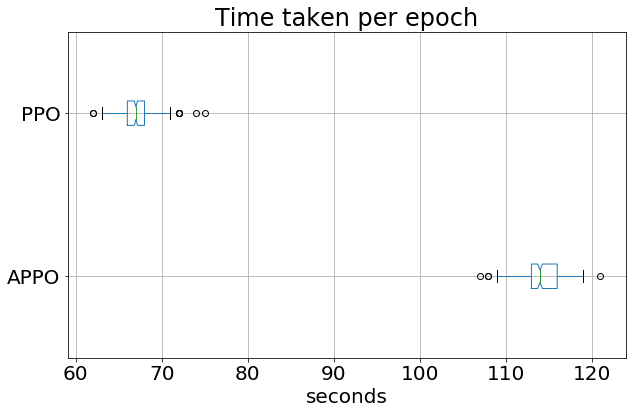

In [7]:
rewards_appo, timestamps_appo = get_stats('/home/alex/appo_vs_ppo_new_w10/appo.pickle')
rewards_ppo, timestamps_ppo = get_stats('/home/alex/appo_vs_ppo_new_w10/ppo.pickle')

df = pd.DataFrame({'APPO':pd.concat([ts.diff() for ts in timestamps_appo]),
                  'PPO':pd.concat([ts.diff() for ts in timestamps_ppo])})
ax = df.boxplot(notch=True, vert=False, figsize=(10, 6), fontsize=20)
ax.set_xlabel("seconds", fontsize=20)
ax.set_title("Time taken per epoch", fontsize=24);